### Simulated Heavy-Ion Collisions with a Generative Adversarial Network

Certain physics models to describe the initially deposited energy density in heavy-ion collisions can be computationally demanding, with the generation of a single event exceeding several core hours. 

These notebooks explore the use of Generative Adversarial Networks (GAN) as a fast and approximate surrogate to model the collision initial conditions. 

Please see this page for a useful introduction to GANs: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/.

### Before running this notebook, one needs to download the event files.
These occupy quite a bit of space and can not be stored on github. 

Please execute `sh prepare.sh` exactly once before running this analysis notebook. 

In [1]:
#! sh prepare.sh #it will take quite a few minutes to download and decompress the events

The downloaded profiles are stored in the `training_profiles` directory.

They have a format which can be read using the function defined below.

Any work which makes reference to this notebook should cite the authors/generators of the profiles:

B. Schenke, P. Tribedy, R. Venugopalan, Fluctuating Glasma Initial Conditions and Flow in Heavy Ion Collisions
Phys. Rev. Lett. 108, 252301 (2012)

B. Schenke, P. Tribedy, R. Venugopalan
Event-by-event gluon multiplicity, energy density, and eccentricities in ultrarelativistic heavy-ion collisions
Phys. Rev. C86, 034908 (2012)

Please see https://quark.phy.bnl.gov/~bschenke/ipglasma-doc.txt for the documentation. 

We begin by importing some necessary libraries...

In [2]:
#Begin by importing some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
sns.set_context('talk')
sns.set_style("darkgrid", {'axes.grid' : False})

The cell below defines a function to read in each profile from disk.

In [3]:
header_list = ['eta', 'x', 'y', 'eps', 'ut', 'ux', 'uy', 'T00', 'T0x', 'T0y', 'T0eta'] 
nx = ny = 200 # the number of pixels (gridpoints) in x and y
dx = dy = 0.17 # the size of each pixel in fm = 10^{-15} m
n_profiles = 3970 # the number of profiles

# the factor by which we coarse-grain.
# profiles should probably only be coarse-grained for testing/debugging purposes
n_coarse = 1  
nx_red = nx / n_coarse
ny_red = ny / n_coarse

def load_ipglasma_profile(i):
    """A function to read in a single ipglasma event profile from disk"""
    df = pd.read_csv('training_profiles/PbPb0-10/epsilon-u-Hydro'+str(i)+'.dat', header=None, 
                 sep=' ', skiprows=1, names=header_list)
    eps = df['eps'].values.reshape(nx, ny)[::n_coarse, ::n_coarse]
    return eps

Let's visualize a randomly selected energy density profile.

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  """


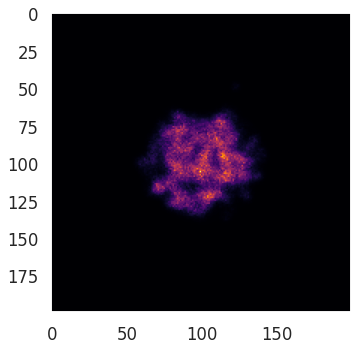

In [4]:
i = np.random.randint(0, high=n_profiles, size=1, dtype='l')[0]
eps = load_ipglasma_profile(i) # the loaded profile
fig, axes = plt.subplots(1,1, figsize=(5,5))
plt.imshow(eps, cmap='inferno')
plt.tight_layout(True)
plt.show()

Typically machine learning models will expect the inputs to be of 'natural' size, not too much smaller or larger than 1. 

Therefore, we will first rescale all of the profiles from $(0, \epsilon_{\rm max}) \rightarrow (0, 1)$.

The choice of the scaling function may be important in the accuracy of the resulting model, and should likely be explored.

In [5]:
#this will loop over all profiles to find eps_max
eps_max = 0.
eps_max = 689.72
#for i in range(1, n_profiles):
#    eps_max = np.maximum(eps_max, load_ipglasma_profile(i).max()  ) 
print("eps_max = " + str(eps_max) )

eps_max = 689.72


In [6]:
rescale_a = 1.
def eps_rescaling_fct(eps_profile, eps_max):
    """Function to rescale the energy density profile to [-1,1]"""
    # a linear rescaling
    return 2.* eps_profile / eps_max - np.ones_like(eps_profile)
    # perhaps non-linear rescaling works better
    #return eps_profile / (rescale_a*np.ones_like(eps_profile) + eps_profile)

def inv_eps_rescaling_fct(eps_profile, eps_max):
    """Function to invert rescaling of energy density profile to [0, eps_max]"""
    # a linear rescaling
    return (eps_profile + np.ones_like(eps_profile)) / 2. * eps_max
    # perhaps non-linear rescaling works better
    #return eps_profile / (rescale_a*np.ones_like(eps_profile) - eps_profile)

Additionally, there is strong evidence that the soft observables in heavy ion collisions are insensitive to small scale geometrical features (features of the order of the pixel size $0.15 $ fm ). Concordantly, to improve the behavior and learning of our model, we will first apply a Gaussian smoothing filter to each training profile. Refs. (https://inspirehep.net/literature/1387518, https://arxiv.org/pdf/1712.03912.pdf) 


The cell below will iteratively load each profile from disk, apply a Guassian filter to smoothen it, then rescale it, and append it to a training array. 

In [7]:
from skimage import filters
# this cell will load each profile from disk, rescale it, apply a smoothing filter
# and append it to the training array

reload_training_profiles = False
sigma_filter = 2 # the pixel size of the Gauss. filter std. dev.
if reload_training_profiles:
    trainX = [] # array of all training images
    for i in range(1, n_profiles+1):
    #for i in range(1, 100):
        eps_profile = load_ipglasma_profile(i) #load profile
        eps_scaled = eps_rescaling_fct(eps_profile, eps_max) #rescale 
        eps_smooth = filters.gaussian(eps_scaled, 
                                              sigma=sigma_filter, 
                                              preserve_range=True) #smoothen 
        
        trainX.append(eps_smooth) #append to training array
    
    trainX = np.array(trainX) #np arrays are nicer
    print(trainX.shape)
    #save the training data to disk, for later convenience
    np.save('training_profiles/trainX', trainX)

If the operation above has already been performed previously, the cell above can be skipped and the training array loaded directly from disk. This is much faster, and is performed in the cell below. 

In [8]:
#load the training profiles array from disk (faster)
trainX = np.load('training_profiles/trainX.npy')
print(trainX.shape)

img_nx = trainX.shape[1] #size of image in x
img_ny = trainX.shape[2] #size of image in x

(3970, 200, 200)


Let's visualize a random profile from the training data. 

Remember, this profile has been smoothened and rescaled with a (perhaps non-linear) scaling function. 

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


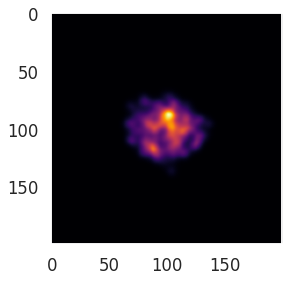

In [9]:
i=np.random.randint(1, high=n_profiles+1, size=1, dtype='l')[0]
plt.imshow(trainX[i], cmap='inferno')
plt.tight_layout(True)
plt.show()

In [ ]:
plt.hist(trainX.flatten(), bins=30, density=True)
plt.show()

## First, we need to define a Discriminator model

It will take an image as input and output a predicted classification, whether it believes the sample is real(1) or fake(0).


The model will use 2D convolution layers. 
It will be trained to minimize the binary cross entropy loss function.

Additionally, we will use the LeakyReLU activation function, dropout layers to prevent overfitting, and the adam SGD optimizer. 

The discriminator model is defined in the cell below. 

Using TensorFlow backend.
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/PAS0254/osu9790/.local/lib/p

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 64)      640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 64)        0         
__________________________

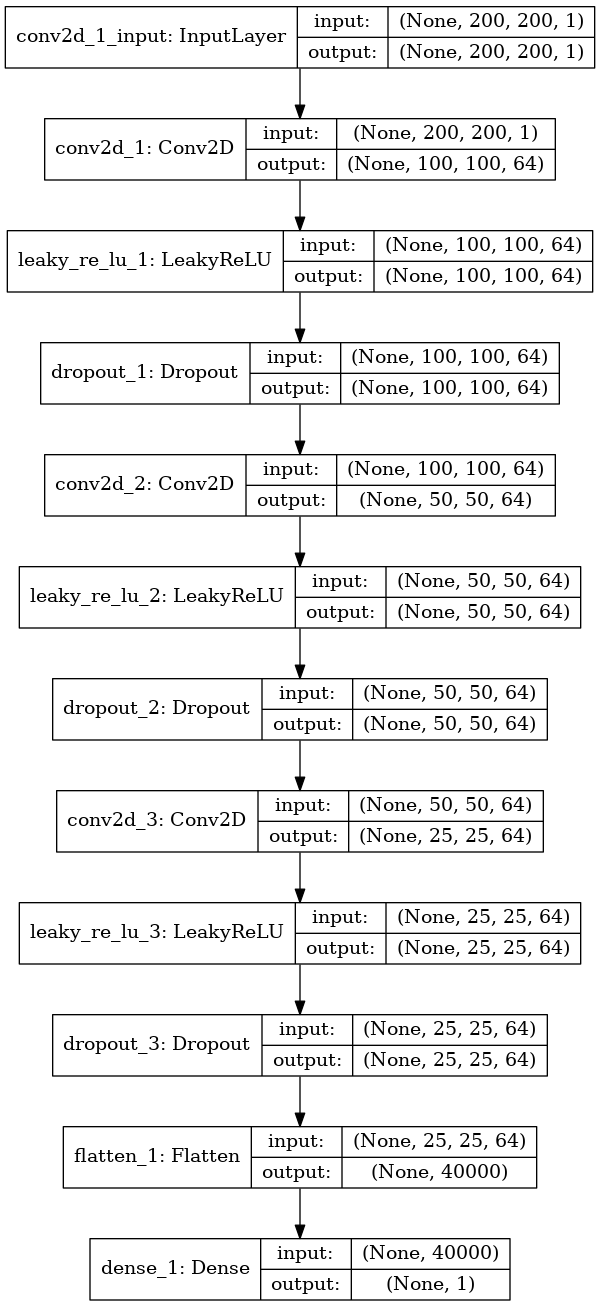

In [10]:
# defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam #the optimizer
from keras.layers import Dense #ordinary dense layer
from keras.layers import Conv2D # the 2D 'convolution' layer
from keras.layers import Flatten 
from keras.layers import Dropout # dropout layers can help prevent overfitting
from keras.layers import LeakyReLU # the activation function
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.utils.vis_utils import plot_model

dropout_rate_d = 0.4 #dropout rate for discriminator 

# define the standalone discriminator model
def define_discriminator(in_shape=(img_nx, img_ny, 1)):
    """A function to yield a discriminator model with input 
    image size img_nx by img_ny"""
    model = Sequential()
    ##########
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout_rate_d))
    ##########
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout_rate_d))
    ##########
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout_rate_d))
    ##########
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5) # lr is the 'learning rate'
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define model
d_model = define_discriminator()
# summarize the model
d_model.summary()
# plot the model
plot_model(d_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
def load_real_samples():
    """Since the CNNs expect images to have a dimension for color channel,
    this function yields a training array of expanded dimension."""
    #there is only one channel (grayscale) but the conv neural network expects 3D arrays
    X = np.expand_dims(trainX, axis=-1) 
    return X

In [12]:
def generate_real_samples(dataset, n_samples):
    """This function will yield n_samples random images and targets
    from the training dataset."""
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)  
    # which denotes it is a real ipglasma image, not fake
    y = np.ones((n_samples, 1))
    return X, y

### Now we need a generator model to generate fake images.

Before it is trained, it will generate 'white noise' -- pixel values uncorrelated point-by-point. 

In [13]:
def generate_fake_samples(n_samples):
    """A function to generate n_samples random images of white noise and targets."""
    # generate uniform random numbers in [0,1]
    X = np.random.rand(img_nx * img_ny * n_samples)
    # reshape into a batch of images
    X = X.reshape((n_samples, img_nx, img_ny, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Now, we can train the discriminator model

We want this model to correctly predict whether a generated image is real or fake. 

In [14]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=256):
    """This function trains the discriminator model on dataset, 
    over n_iter epochs each with a batch size of n_batch."""
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly sampled 'real' images
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [15]:
# define the discriminator model
d_model = define_discriminator()
# load image data
dataset = load_real_samples()
# train the discrimnator model
train_discriminator(d_model, dataset, n_iter=20)

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_4/convolution}}]]
	 [[metrics_1/accuracy/Identity/_141]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_4/convolution}}]]
0 successful operations.
0 derived errors ignored.

### Now we have a trained discriminator model!

### A generator model is supposed to create 'fake' images, until it is trained.

### But after it is trained, we want it to create 'plausible' images, that can 'fool' the discriminator. 

The model proceeds as follows:
First, it will draw a sample from a 'latent space' -- a vector space of Gaussian distributed random variables. 

Then, through a series of deconvolutions, activation functions, etc... it will generate an image of the correct size.

The first layer will be a dense hidden layer with enough nodes to represent a 'low resolution' version of the image. 

Actually, we want many parallell versions of this low-res image. 
The first layer will allow for 128 parallel versions of the 'feature map'. 

Next we need to 'upsample' (or 'deconcolve'), with a 'Conv2dTranpose' layer.

In [ ]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def define_generator(latent_dim):
    n_poss_im = 128
    size_base = 25 # pixels of base image
    """Function which yields an image generator model
    from a latent space vector of dimension latent_dim."""
    model = Sequential()
    # foundation image
    n_nodes = n_poss_im * size_base * size_base # the n_poss_im low resolution base images
    model.add(Dense(n_nodes, input_dim=latent_dim))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Activation("relu"))
    model.add(Reshape((size_base, size_base, n_poss_im)))
    
    # upsample by factor stride_1
    stride_1 = 2
    kern_1 = 2*stride_1
    #make sure kernel size is an integer factor of stride, n*stride
    model.add(Conv2DTranspose(n_poss_im, (kern_1,kern_1), strides=(stride_1,stride_1), 
                              padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Activation("relu"))
    
    # upsample by factor stride_2
    stride_2 = 2
    kern_2 = 2*stride_2
    #make sure kernel size is an integer factor of stride, n*stride
    model.add(Conv2DTranspose(n_poss_im, (kern_2,kern_2), strides=(stride_2,stride_2), 
                              padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Activation("relu"))
    
    # upsample by factor stride_3
    stride_3 = 2
    kern_3 = 2*stride_3
    model.add(Conv2DTranspose(n_poss_im, (kern_3,kern_3), strides=(stride_3,stride_3), padding='same'))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Activation("tanh"))
    #model.add(Conv2D(1, (size_base, size_base), activation='sigmoid', padding='same'))
    model.add(Conv2D(1, (size_base, size_base), activation='tanh', padding='same'))
    return model

The cell below will define the compile the generator model, without training it. 

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    """A function to generate n_samples samples of vectors in 
    the latent space of dimension latent_dim."""
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    """A function to generate n_samples images from the generator model
    g_model, from latent space dimension latent_dim."""
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

Our generator model is yet untrained (the network weights are random and not optimized).

But we can still use it to generate random images, to see how/whether it is working as expected. 

In [ ]:
# now lets generate random points in latent space, 
# and push these forward through the (untrained) generative model

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 9
X, _ = generate_fake_samples(model, latent_dim, n_samples)

fig, axes = plt.subplots(3,3, figsize=(10,10))
# plot the generated samples
for i, ax in enumerate(axes.flatten()):
    # plot single image
    ax.imshow(X[i, :, :, 0], cmap='inferno')
# show the figure
plt.tight_layout(True)
plt.show()

### Since the generative model hasn't been trained, it just generated noise

### Now we want to combine the generator and discriminator together into a GAN

The simplest approach is to create a new Sequential model that combines the generator and discriminator models.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    """Yields a GAN model composed of generator g_model and
    discriminator d_model."""
    # make weights in the discriminator not trainable inside the gan model
    d_model.trainable = False
    # connect them in sequence
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.9) # 'learning rate' lr=0.0002
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator (why do we do this again, it has already been trained...)
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True)

In [ ]:
def save_plot(examples, epoch, n=10):
    """This function will allow use to periodically 
    plot the performance of the GAN during training. It 
    will plot n*n images from the data examples. """
    # plot images
    fig,axes = plt.subplots(n, n, figsize=(3*n, 3*n))
    for i, ax in enumerate(axes.flatten()):
        eps_scaled = examples[i, :, :, 0] #get the scaled prediction
        eps = inv_eps_rescaling_fct(eps_scaled, eps_max) #undo the rescaling
        ax.imshow(eps, cmap='inferno')
    # save plot to file
    filename = 'generated_profiles/generated_plot_e%03d.png' % (epoch+1)
    plt.tight_layout(True)
    plt.savefig(filename)
    plt.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    """A function to periodically evaluate the performance of the 
    discriminator d_model and generator g_model."""
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch, n=5)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save('generators/' + filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
    """A function to train the discriminator d_model and generator g_model together,
    iteratively over n_epochs epochs, with a batch size of n_batch."""
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=100)

In [ ]:
from keras.models import load_model
def predict_profile_gan():
    model = load_model('generators/generator_model_060.h5')
    latent_points = generate_latent_points(latent_dim, 1)
    pred = model.predict(latent_points)[0,:,:,0]
    eps = inv_eps_rescaling_fct(pred, eps_max)
    return eps

In [ ]:
pred_eps = predict_profile_gan()
plt.imshow(pred_eps, cmap='inferno')
plt.tight_layout(True)
plt.show()